In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import matplotlib.pyplot as plt

np.seterr(divide='ignore')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)}, threshold=sys.maxsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# --- 3. Material Properties ---
E = 200e9  # Young's Modulus in Pascals
lrt = 2e9
lrc = 700e6

rho = 2000

K_eff = 0.8

In [93]:
# Geometric constraints and system parameters
total_length = 0.85
load_mag = 60

In [94]:
# Input parameters
base_scale = 0.15
taper_ratio = 0.25

diam_sq_o = 1e-3
diam_zc_o = 3.5e-3
diam_dg_o = 2.5e-3

diam_o = np.array([diam_sq_o, diam_zc_o, diam_dg_o])

diam_sq_i = 0
diam_zc_i = 2.5e-3
diam_dg_i = 1.5e-3

diam_i = np.array([diam_sq_i, diam_zc_i, diam_dg_i])

z_spacings = (np.arange(5)/(5-1))**0.93

In [108]:
%autoreload 2
from truss_geometry import square_truss_geometry
nodes, elements, element_kind = square_truss_geometry(base_scale, taper_ratio, z_spacings, total_length)

In [ ]:
%autoreload 2
from fem import build_fem_system

(
    dofs,
    n_dofs,
    element_area,
    element_I,
    element_length,
    dxyz,
    constraints,
    fixed_nodes,
    load_nodes,
    load_magnitudes,
    total_mass,
) = build_fem_system(
    nodes, elements, element_kind, diam_o, diam_i, rho, load_mag, z_spacings
)


num_nodes = nodes.shape[0]

print(f"Number of nodes: {num_nodes}")
print("Nodal Coordinates (x, y, z):")
print(nodes)


num_elements = elements.shape[0]

print(f"\nNumber of elements: {num_elements}")
print("Element Connectivity (Node_i, Node_j):")
print(elements)

print()

print(f"Total length of elements: {total_length:.2f} m")
print(f"Total mass of elements: {total_mass:.2f} m")

print("\nFixed Nodes")
for node_idx in fixed_nodes:
    print(f"Node {node_idx}: constrained in all directions")

print("\nApplied Loads (Node_idx, Magnitude):")
for load_node, magnitude in zip(load_nodes, load_magnitudes):
    print(f"Node {load_node[0]}: load in dof {load_node[1]} = {magnitude} N")

Number of nodes: 20
Nodal Coordinates (x, y, z):
[[-7.500e-02 -7.500e-02 0.000e+00]
 [-7.500e-02 7.500e-02 0.000e+00]
 [7.500e-02 7.500e-02 0.000e+00]
 [7.500e-02 -7.500e-02 0.000e+00]
 [-5.950e-02 -5.950e-02 2.342e-01]
 [-5.950e-02 5.950e-02 2.342e-01]
 [5.950e-02 5.950e-02 2.342e-01]
 [5.950e-02 -5.950e-02 2.342e-01]
 [-4.548e-02 -4.548e-02 4.461e-01]
 [-4.548e-02 4.548e-02 4.461e-01]
 [4.548e-02 4.548e-02 4.461e-01]
 [4.548e-02 -4.548e-02 4.461e-01]
 [-3.195e-02 -3.195e-02 6.505e-01]
 [-3.195e-02 3.195e-02 6.505e-01]
 [3.195e-02 3.195e-02 6.505e-01]
 [3.195e-02 -3.195e-02 6.505e-01]
 [-1.875e-02 -1.875e-02 8.500e-01]
 [-1.875e-02 1.875e-02 8.500e-01]
 [1.875e-02 1.875e-02 8.500e-01]
 [1.875e-02 -1.875e-02 8.500e-01]]

Number of elements: 52
Element Connectivity (Node_i, Node_j):
[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  0]
 [ 0  4]
 [ 1  5]
 [ 2  6]
 [ 3  7]
 [ 1  4]
 [ 2  5]
 [ 3  6]
 [ 0  7]
 [ 4  5]
 [ 5  6]
 [ 6  7]
 [ 7  4]
 [ 4  8]
 [ 5  9]
 [ 6 10]
 [ 7 11]
 [ 5  8]
 [ 6  9]
 [ 7 10]


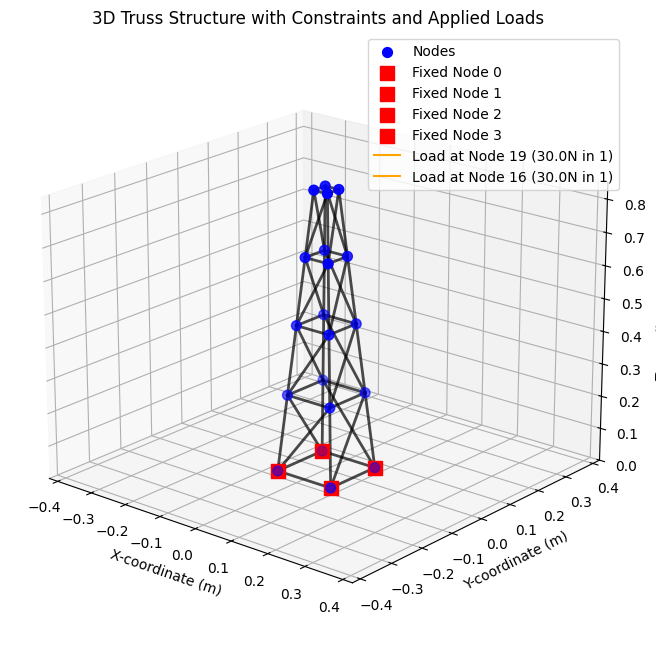

3D visualization of the truss structure, constraints, and loads generated.


In [119]:
# Create a new figure and a 3D axes object for visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], color='blue', s=50, label='Nodes')

# Plot elements (truss members)
for element in elements:
    node1_idx, node2_idx = int(element[0]), int(element[1])
    node1_coords = nodes[node1_idx]
    node2_coords = nodes[node2_idx]
    ax.plot([node1_coords[0], node2_coords[0]],
            [node1_coords[1], node2_coords[1]],
            [node1_coords[2], node2_coords[2]], 'k-', linewidth=2, alpha=0.7)

# Plot fixed nodes (constraints)
for node_idx in fixed_nodes:
    node_coords = nodes[node_idx]
    # Use a larger, red marker for fixed nodes
    ax.scatter(node_coords[0], node_coords[1], node_coords[2], color='red', marker='s', s=100, label=f'Fixed Node {node_idx}')

# Plot applied loads as arrows
# Scale for load arrows (adjust as needed for better visualization)
max_load_magnitude = max(load_magnitudes)
arrow_scale = 0.05 / max_load_magnitude if max_load_magnitude != 0 else 0.1

for load_node, magnitude in zip(load_nodes, load_magnitudes):
    node_idx, dof_type = load_node
    node_coords = nodes[node_idx]
    x_start, y_start, z_start = node_coords

    # Initialize direction vector components
    u, v, w = 0, 0, 0

    # Set component based on dof_type
    if dof_type == 'x':
        u = magnitude * arrow_scale
    elif dof_type == 'y':
        v = magnitude * arrow_scale
    elif dof_type == 'z':
        w = magnitude * arrow_scale

    # Plot the arrow using quiver
    ax.quiver(x_start, y_start, z_start, u, v, w, color='orange', length=1, arrow_length_ratio=0.25, label=f'Load at Node {node_idx} ({magnitude}N in {dof_type})')

# Set labels and title
ax.set_xlabel('X-coordinate (m)')
ax.set_ylabel('Y-coordinate (m)')
ax.set_zlabel('Z-coordinate (m)')
ax.set_title('3D Truss Structure with Constraints and Applied Loads')

# Add a legend to distinguish nodes, elements, fixed nodes, and loads
handles, labels = ax.get_legend_handles_labels()
# Filter out duplicate labels and ensure order
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# Calculate max range for all axes
max_range = np.array([nodes[:,0].max()-nodes[:,0].min(),
                      nodes[:,1].max()-nodes[:,1].min(),
                      nodes[:,2].max()-nodes[:,2].min()]).max()

# Get midpoints for each axis
mid_x = (nodes[:,0].max()+nodes[:,0].min()) * 0.5
mid_y = (nodes[:,1].max()+nodes[:,1].min()) * 0.5
mid_z = (nodes[:,2].max()+nodes[:,2].min()) * 0.5

# Set equal limits
ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)

# Adjust the view angle for better visualization if needed
ax.view_init(elev=20, azim=-50)
ax.grid(True)
plt.show()

print("3D visualization of the truss structure, constraints, and loads generated.")

In [120]:
%autoreload 2
from fem import build_K_global, build_F_global, apply_constraints

K_global = build_K_global(dofs, n_dofs, element_area, element_length, dxyz, E)
print("Global Stiffness Matrix (K_global) assembled for 3D.")

F_global = build_F_global(load_nodes, load_magnitudes, n_dofs)
print("Global Load Vector (F_global) assembled for 3D.")


K_reduced, F_reduced, unconstrained_dofs = apply_constraints(K_global, F_global, constraints, fixed_nodes, n_dofs)

print(f"Unconstrained DOFs: {unconstrained_dofs}")


print(f"K_global shape: {K_global.shape}")
print(f"F_global shape: {F_global.shape}")
print(f"K_reduced shape: {K_reduced.shape}")
print(f"F_reduced shape: {F_reduced.shape}")

Global Stiffness Matrix (K_global) assembled for 3D.
Global Load Vector (F_global) assembled for 3D.
Unconstrained DOFs: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
K_global shape: (60, 60)
F_global shape: (60,)
K_reduced shape: (48, 48)
F_reduced shape: (48,)


In [122]:
%autoreload 2
from fem import solve_fem

U_global = solve_fem(K_reduced, F_reduced, unconstrained_dofs, n_dofs)

# 4. Print the final U_global vector
print("\nNodal Displacements (U_global):")
print(U_global)

# 5. Print displacements per node for clarity
print("\nNodal Displacements (x, y, z) per Node:")
for i in range(num_nodes):
    ux = U_global[3 * i]
    uy = U_global[3 * i + 1]
    uz = U_global[3 * i + 2]
    print(f"Node {i}: dx = {ux:.6e} m, dy = {uy:.6e} m, dz = {uz:.6e} m")


Nodal Displacements (U_global):
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 -6.100e-05 8.003e-05
 4.153e-05 -6.100e-05 8.719e-05 -2.927e-05 -6.100e-05 8.003e-05 -4.153e-05
 -6.100e-05 8.719e-05 2.927e-05 -9.407e-05 2.940e-04 6.494e-05 -9.407e-05
 3.011e-04 -4.328e-05 -9.407e-05 2.940e-04 -6.494e-05 -9.407e-05 3.011e-04
 4.328e-05 -9.270e-05 6.445e-04 7.092e-05 -9.270e-05 6.516e-04 -4.075e-05
 -9.270e-05 6.445e-04 -7.092e-05 -9.270e-05 6.516e-04 4.075e-05 4.736e-18
 1.164e-03 5.048e-05 2.791e-19 1.164e-03 -1.297e-05 2.816e-19 1.164e-03
 -5.048e-05 4.735e-18 1.171e-03 1.249e-05]

Nodal Displacements (x, y, z) per Node:
Node 0: dx = 0.000000e+00 m, dy = 0.000000e+00 m, dz = 0.000000e+00 m
Node 1: dx = 0.000000e+00 m, dy = 0.000000e+00 m, dz = 0.000000e+00 m
Node 2: dx = 0.000000e+00 m, dy = 0.000000e+00 m, dz = 0.000000e+00 m
Node 3: dx = 0.000000e+00 m, dy = 0.000000e+00 m, dz = 0.000000e+00 m
Node 4: dx = -6.

In [123]:
%autoreload 2
from fem import element_strain

strain = element_strain(U_global, dxyz, element_length, dofs)

axial_forces = E * element_area * strain
axial_stresses = axial_forces / (element_area)

print("\n--- Member Forces and Stresses (3D Truss) ---")
for i in range(num_elements):
    force_type = "Tension" if axial_forces[i] > 0 else "Compression"
    print(f"Element {i}: Force = {axial_forces[i]:.2f} N ({force_type}), Stress = {axial_stresses[i]:.2e} Pa")


--- Member Forces and Stresses (3D Truss) ---
Element 0: Force = 0.00 N (Compression), Stress = 0.00e+00 Pa
Element 1: Force = 0.00 N (Compression), Stress = 0.00e+00 Pa
Element 2: Force = 0.00 N (Compression), Stress = 0.00e+00 Pa
Element 3: Force = 0.00 N (Compression), Stress = 0.00e+00 Pa
Element 4: Force = 170.74 N (Tension), Stress = 3.62e+07 Pa
Element 5: Force = -155.92 N (Compression), Stress = -3.31e+07 Pa
Element 6: Force = -170.74 N (Compression), Stress = -3.62e+07 Pa
Element 7: Force = 155.92 N (Tension), Stress = 3.31e+07 Pa
Element 8: Force = -17.05 N (Compression), Stress = -5.43e+06 Pa
Element 9: Force = 0.00 N (Tension), Stress = 4.40e-08 Pa
Element 10: Force = 17.05 N (Tension), Stress = 5.43e+06 Pa
Element 11: Force = 0.00 N (Tension), Stress = 5.79e-08 Pa
Element 12: Force = 9.45 N (Tension), Stress = 1.20e+07 Pa
Element 13: Force = -0.00 N (Compression), Stress = -1.37e-07 Pa
Element 14: Force = -9.45 N (Compression), Stress = -1.20e+07 Pa
Element 15: Force = -0

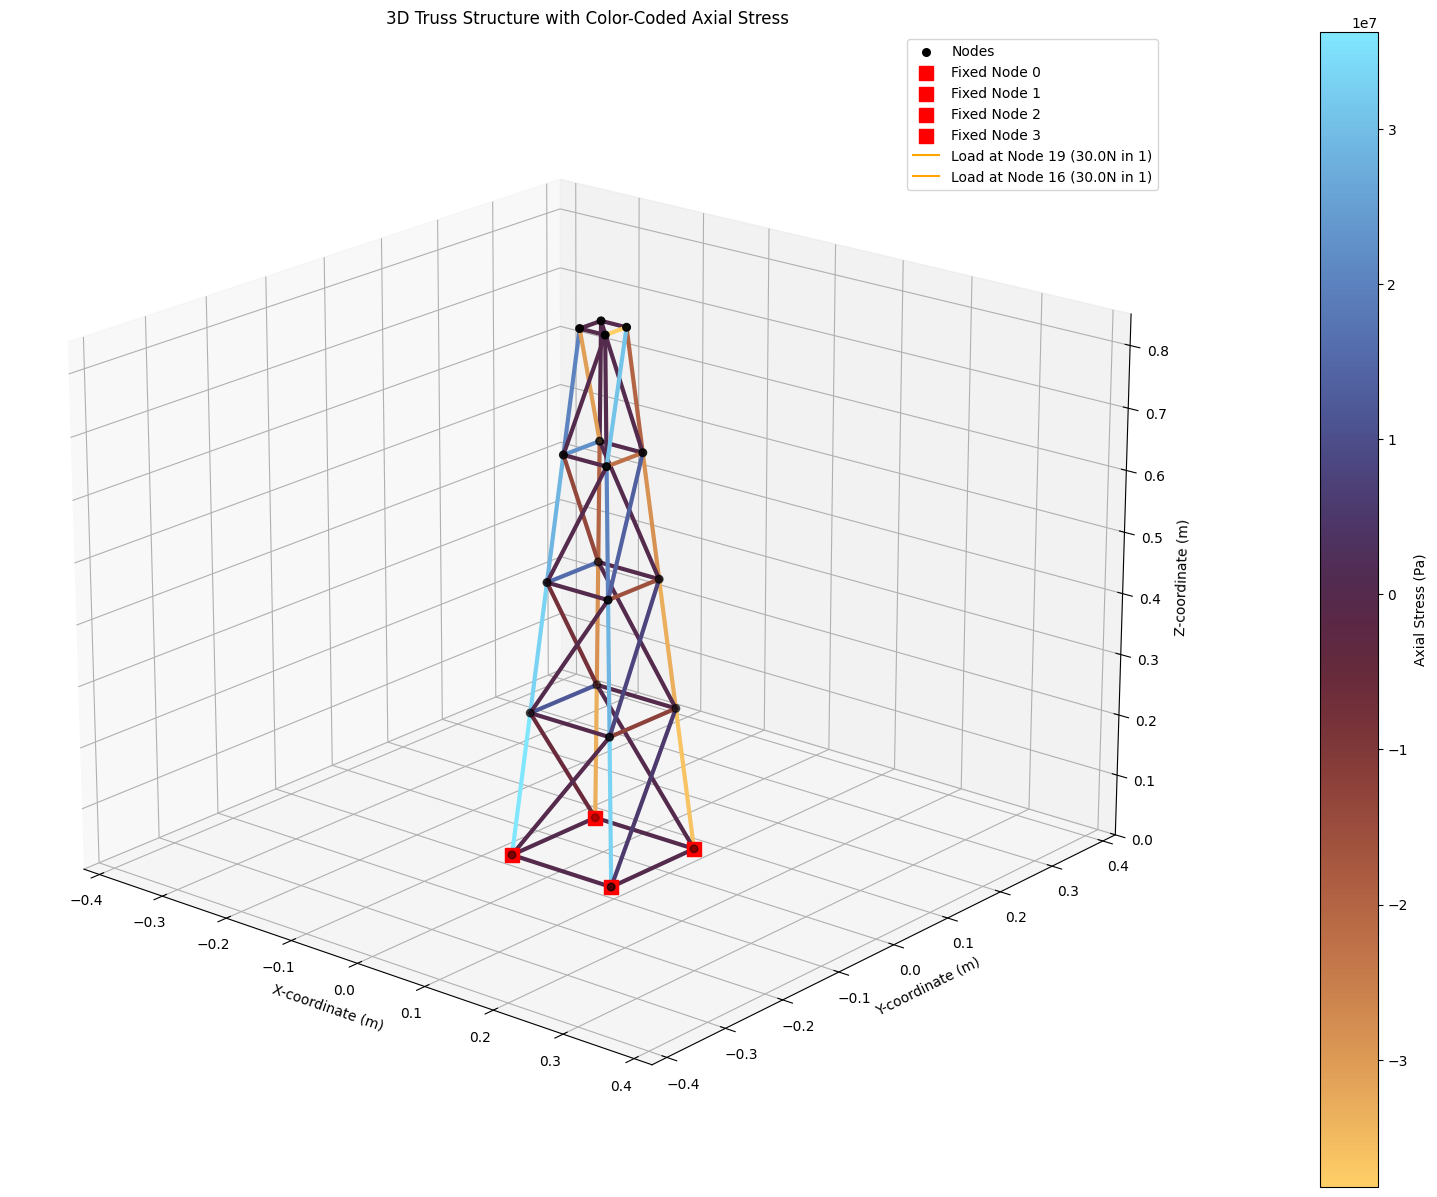

3D visualization of the truss structure with color-coded axial stresses generated.


In [125]:
import matplotlib.cm as cm

# Create a new figure and a 3D axes object for visualization
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

# 2. Plot the nodes as scatter points
ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], color='black', s=30, label='Nodes')

# Normalize stress values for color mapping
# Ensure min/max are not identical to avoid division by zero in normalization
min_stress = np.min(axial_stresses)
max_stress = np.max(axial_stresses)

if min_stress == max_stress:
    # Handle case where all stresses are the same
    normalized_stresses = np.zeros_like(axial_stresses)
else:
    normalized_stresses = (axial_stresses - min_stress) / (max_stress - min_stress)

# Choose a colormap (RdBu_r for red=compression, blue=tension)
cmap = cm.managua

# 3. Iterate through each element and plot the beams with color-coding
for i, element in enumerate(elements):
    node1_idx, node2_idx = element

    # Get coordinates of the connected nodes (3D)
    x1, y1, z1 = nodes[node1_idx]
    x2, y2, z2 = nodes[node2_idx]

    # Get stress for the current element
    stress = axial_stresses[i]

    # Get color from colormap based on normalized stress
    color = cmap(normalized_stresses[i])

    # Plot the beam
    ax.plot([x1, x2], [y1, y2], [z1, z2], color=color, linewidth=3)



# Plot fixed nodes (constraints)
for node_idx in fixed_nodes:
    node_coords = nodes[node_idx]
    # Use a larger, red marker for fixed nodes
    ax.scatter(node_coords[0], node_coords[1], node_coords[2], color='red', marker='s', s=100, label=f'Fixed Node {node_idx}')

# Plot applied loads as arrows
# Scale for load arrows (adjust as needed for better visualization)
max_load_magnitude = max(load_magnitudes)
arrow_scale = 0.05 / max_load_magnitude if max_load_magnitude != 0 else 0.1

for load_node, magnitude in zip(load_nodes, load_magnitudes):
    node_idx, dof_type = load_node
    node_coords = nodes[node_idx]
    x_start, y_start, z_start = node_coords

    # Initialize direction vector components
    u, v, w = 0, 0, 0

    # Set component based on dof_type
    if dof_type == 'x':
        u = magnitude * arrow_scale
    elif dof_type == 'y':
        v = magnitude * arrow_scale
    elif dof_type == 'z':
        w = magnitude * arrow_scale

    # Plot the arrow using quiver
    ax.quiver(x_start, y_start, z_start, u, v, w, color='orange', length=1, arrow_length_ratio=0.25, label=f'Load at Node {node_idx} ({magnitude}N in {dof_type})')

# 4. Add labels for the x, y, and z axes
ax.set_xlabel('X-coordinate (m)')
ax.set_ylabel('Y-coordinate (m)')
ax.set_zlabel('Z-coordinate (m)')

# 5. Set an appropriate title for the plot
ax.set_title('3D Truss Structure with Color-Coded Axial Stress')

# 6. Add a color bar to explain the stress-color mapping
sm = cm.ScalarMappable(cmap=cmap)
sm.set_array([min_stress, max_stress]) # Set the range for the colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Axial Stress (Pa)')

# Add a legend to distinguish nodes, elements, fixed nodes, and loads
handles, labels = ax.get_legend_handles_labels()
# Filter out duplicate labels and ensure order
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# Calculate max range for all axes
max_range = np.array([nodes[:,0].max()-nodes[:,0].min(),
                      nodes[:,1].max()-nodes[:,1].min(),
                      nodes[:,2].max()-nodes[:,2].min()]).max()

# Get midpoints for each axis
mid_x = (nodes[:,0].max()+nodes[:,0].min()) * 0.5
mid_y = (nodes[:,1].max()+nodes[:,1].min()) * 0.5
mid_z = (nodes[:,2].max()+nodes[:,2].min()) * 0.5

# Set equal limits
ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)

# Adjust the view angle for better visualization if needed
ax.view_init(elev=20, azim=-50)
ax.grid(True)
plt.show()

print("3D visualization of the truss structure with color-coded axial stresses generated.")

In [126]:
print("\n--- Summary of Maximum Tension and Compression ---")

# Find maximum tensile stress
max_tension_stress = np.max(axial_stresses)
max_tension_idx = np.argmax(axial_stresses)

# Find maximum compressive stress (most negative value)
max_compression_stress = np.min(axial_stresses)
max_compression_idx = np.argmin(axial_stresses)

# Get element details for max tension
element_tension = elements[max_tension_idx]
node1_coords_tension = nodes[element_tension[0]]
node2_coords_tension = nodes[element_tension[1]]
L_tension = np.sqrt(np.sum((node2_coords_tension - node1_coords_tension)**2))

# Get element details for max compression
element_compression = elements[max_compression_idx]
node1_coords_compression = nodes[element_compression[0]]
node2_coords_compression = nodes[element_compression[1]]
L_compression = np.sqrt(np.sum((node2_coords_compression - node1_coords_compression)**2))

print(f"Maximum Tensile Stress: {max_tension_stress:.2e} Pa")
print(f"  Occurs in Element {max_tension_idx} (Nodes {element_tension[0]} and {element_tension[1]}) with length {L_tension:.2f} m")
print(f"Maximum Compressive Stress: {max_compression_stress:.2e} Pa")
print(f"  Occurs in Element {max_compression_idx} (Nodes {element_compression[0]} and {element_compression[1]}) with length {L_compression:.2f} m")


--- Summary of Maximum Tension and Compression ---
Maximum Tensile Stress: 3.62e+07 Pa
  Occurs in Element 4 (Nodes 0 and 4) with length 0.24 m
Maximum Compressive Stress: -3.82e+07 Pa
  Occurs in Element 50 (Nodes 18 and 19) with length 0.04 m


In [135]:
%autoreload 2
from fem import calculate_SF

tension_sf, compression_sf, buckling_sf, node_deflection = calculate_SF(
    dofs, U_global, dxyz, element_length, element_area, element_I, E, K_eff, lrt, lrc
)

min_tension_sf = np.min(tension_sf)
min_compression_sf = np.min(compression_sf)
min_buckling_sf = np.min(buckling_sf)

max_def = np.max(node_deflection)

print(f"Minimum Tensile SF: {min_tension_sf:.2e}")
print(f"Minimum Compressive SF: {min_compression_sf:.2e}")
print(f"Minimum Buckling SF: {min_buckling_sf:.2e}")
print(f"Maximum deflection: {1000*max_def:.2e} mm")

Minimum Tensile SF: 5.52e+01
Minimum Compressive SF: 1.83e+01
Minimum Buckling SF: 1.13e+00
Maximum deflection: 1.37e-03 mm


c:\Users\User\Documents\Coisas\Study\UFGD\Aracs\2026\Projects\cf_truss_generator\fem.py:5: RuntimeWarning: divide by zero encountered in divide
  
c:\Users\User\Documents\Coisas\Study\UFGD\Aracs\2026\Projects\cf_truss_generator\fem.py:6: RuntimeWarning: divide by zero encountered in divide
  def build_fem_system(
c:\Users\User\Documents\Coisas\Study\UFGD\Aracs\2026\Projects\cf_truss_generator\fem.py:7: RuntimeWarning: divide by zero encountered in divide
  nodes, elements, element_kind, diam_o, diam_i, rho, load_mag, z_spacings


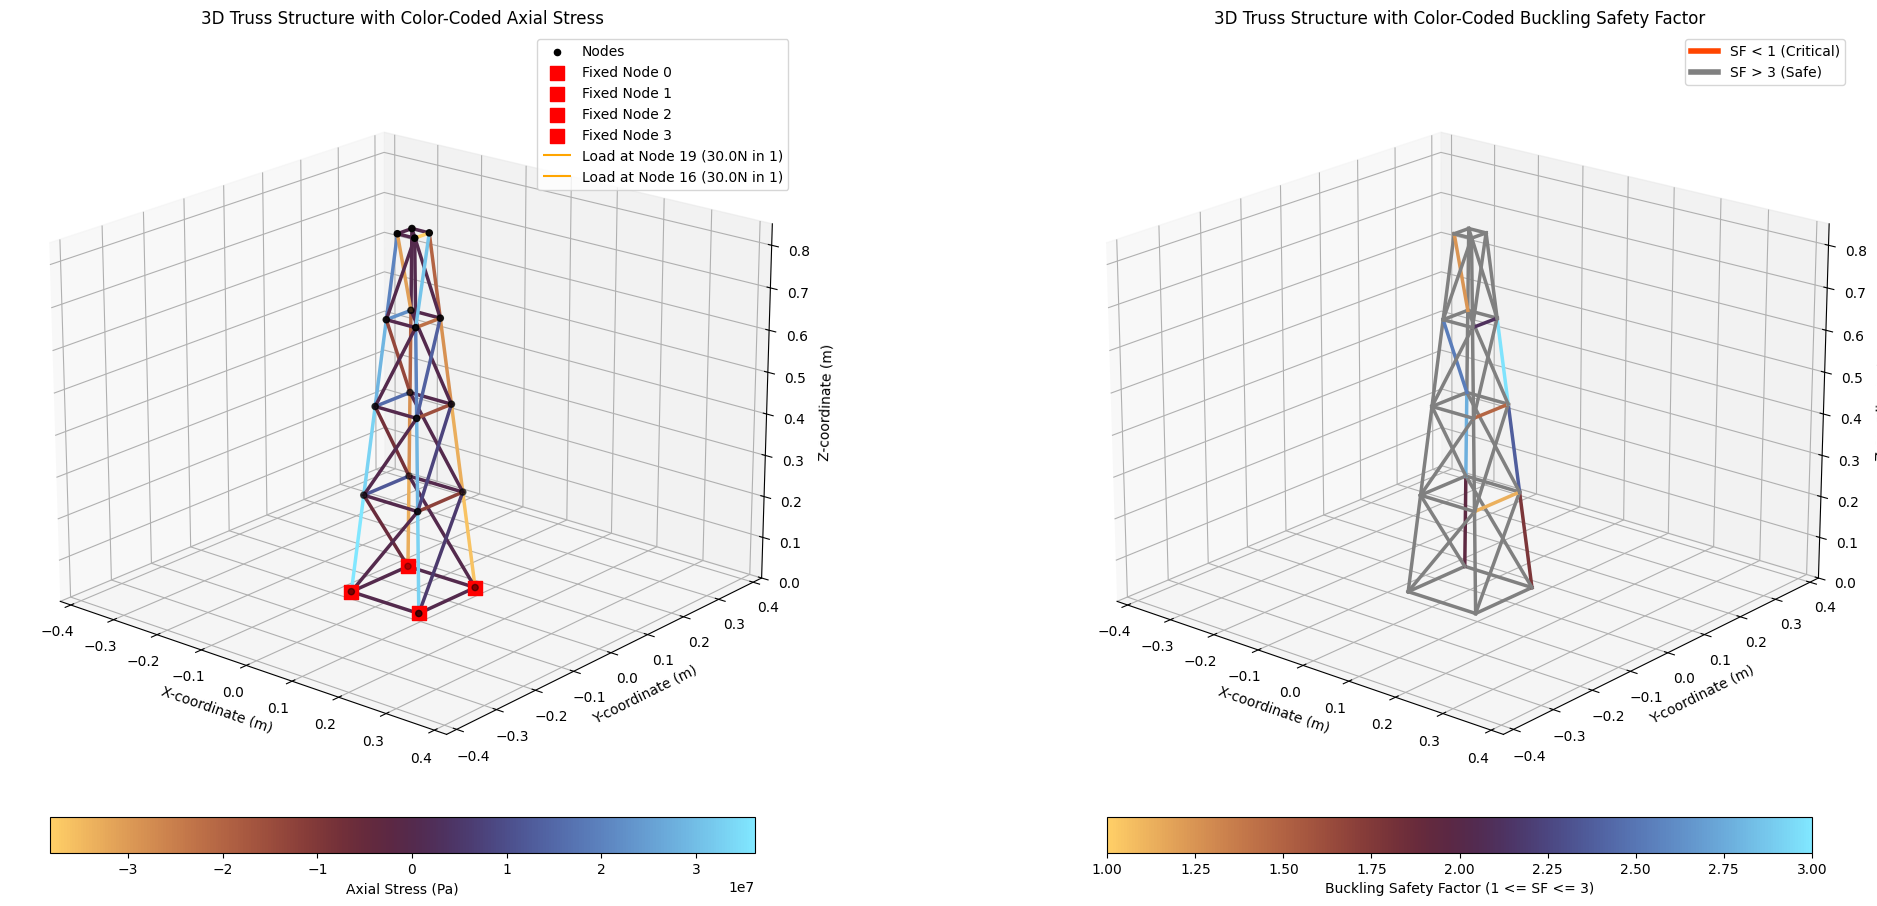

In [136]:
from matplotlib.lines import Line2D

# Create a new figure and a 3D axes object for visualization
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(121, projection='3d')

# 2. Plot the nodes as scatter points
ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], color='black', s=20, label='Nodes')

# Normalize stress values for color mapping
# Ensure min/max are not identical to avoid division by zero in normalization
min_stress = np.min(axial_stresses)
max_stress = np.max(axial_stresses)

if min_stress == max_stress:
    # Handle case where all stresses are the same
    normalized_stresses = np.zeros_like(axial_stresses)
else:
    normalized_stresses = (axial_stresses - min_stress) / (max_stress - min_stress)

# Choose a colormap (RdBu_r for orangered=compression, blue=tension)
cmap = cm.managua

# 3. Iterate through each element and plot the beams with color-coding
for i, element in enumerate(elements):
    node1_idx, node2_idx = element

    # Get coordinates of the connected nodes (3D)
    x1, y1, z1 = nodes[node1_idx]
    x2, y2, z2 = nodes[node2_idx]

    # Get stress for the current element
    stress = axial_stresses[i]

    # Get color from colormap based on normalized stress
    color = cmap(normalized_stresses[i])

    # Plot the beam
    ax.plot([x1, x2], [y1, y2], [z1, z2], color=color, linewidth=2.5)


# Plot fixed nodes (constraints)
for node_idx in fixed_nodes:
    node_coords = nodes[node_idx]
    # Use a larger, red marker for fixed nodes
    ax.scatter(node_coords[0], node_coords[1], node_coords[2], color='red', marker='s', s=100, label=f'Fixed Node {node_idx}')

# Plot applied loads as arrows
# Scale for load arrows (adjust as needed for better visualization)
max_load_magnitude = max(load_magnitudes)
arrow_scale = 0.05 / max_load_magnitude if max_load_magnitude != 0 else 0.1

for load_node, magnitude in zip(load_nodes, load_magnitudes):
    node_idx, dof_type = load_node
    node_coords = nodes[node_idx]
    x_start, y_start, z_start = node_coords

    # Initialize direction vector components
    u, v, w = 0, 0, 0

    # Set component based on dof_type
    if dof_type == 'x':
        u = magnitude * arrow_scale
    elif dof_type == 'y':
        v = magnitude * arrow_scale
    elif dof_type == 'z':
        w = magnitude * arrow_scale

    # Plot the arrow using quiver
    ax.quiver(x_start, y_start, z_start, u, v, w, color='orange', length=1, arrow_length_ratio=0.25, label=f'Load at Node {node_idx} ({magnitude}N in {dof_type})')

# 4. Add labels for the x, y, and z axes
ax.set_xlabel('X-coordinate (m)')
ax.set_ylabel('Y-coordinate (m)')
ax.set_zlabel('Z-coordinate (m)')

# 5. Set an appropriate title for the plot
ax.set_title('3D Truss Structure with Color-Coded Axial Stress')

# 6. Add a color bar to explain the stress-color mapping
sm = cm.ScalarMappable(cmap=cmap)
sm.set_array([min_stress, max_stress]) # Set the range for the colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0, shrink=0.8, location='bottom')
cbar.set_label('Axial Stress (Pa)')

# Add a legend to distinguish nodes, elements, fixed nodes, and loads
handles, labels = ax.get_legend_handles_labels()
# Filter out duplicate labels and ensure order
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# Calculate max range for all axes
max_range = np.array([nodes[:,0].max()-nodes[:,0].min(),
                      nodes[:,1].max()-nodes[:,1].min(),
                      nodes[:,2].max()-nodes[:,2].min()]).max()

# Get midpoints for each axis
mid_x = (nodes[:,0].max()+nodes[:,0].min()) * 0.5
mid_y = (nodes[:,1].max()+nodes[:,1].min()) * 0.5
mid_z = (nodes[:,2].max()+nodes[:,2].min()) * 0.5

# Set equal limits
ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)

# Adjust the view angle for better visualization if needed
ax.view_init(elev=20, azim=-50)
ax.grid(True)


ax = fig.add_subplot(122, projection='3d')

# Define colormap for the 1 <= SF <= 2 range
cmap_sf = cm.managua

# Iterate through each element and plot the beams with color-coding based on buckling safety factor
for i, element in enumerate(elements):
    node1_idx, node2_idx = element

    # Get coordinates of the connected nodes (3D)
    x1, y1, z1 = nodes[node1_idx]
    x2, y2, z2 = nodes[node2_idx]

    # Get buckling safety factor for the current element
    sf = buckling_sf[i]

    if sf < 1:
        color = 'orangered'  # Critical: SF < 1
    elif sf > 3:
        color = 'gray'  # Safe: SF > 2
    else: # 1 <= sf <= 2, use 'managua' gradient
        # Normalize sf within the [1, 2] range for colormap
        normalized_sf = (sf - 1) / (3 - 1) if (3 - 1) != 0 else 0
        color = cmap_sf(normalized_sf)

    # Plot the beam
    ax.plot([x1, x2], [y1, y2], [z1, z2], color=color, linewidth=2.5)

# Add labels for the x, y, and z axes
ax.set_xlabel('X-coordinate (m)')
ax.set_ylabel('Y-coordinate (m)')
ax.set_zlabel('Z-coordinate (m)')

# Update Plot Title
ax.set_title('3D Truss Structure with Color-Coded Buckling Safety Factor')

# Update Color Bar for Buckling Safety Factor
sm_sf = cm.ScalarMappable(cmap=cmap_sf)
sm_sf.set_array([1, 3]) # Set the range for the colorbar gradient
cbar = fig.colorbar(sm_sf, ax=ax, pad=0, shrink=0.8, label='Buckling Safety Factor (1 <= SF <= 3)', location='bottom')

# Add custom legend entries for SF < 1 and SF > 2
custom_lines = [
    Line2D([0], [0], color='orangered', lw=4, label='SF < 1 (Critical)'),
    Line2D([0], [0], color='gray', lw=4, label='SF > 3 (Safe)')
]

# Add a legend to distinguish nodes, fixed nodes, loads, and custom SF ranges
handles, labels = ax.get_legend_handles_labels()
# Filter out duplicate labels and ensure order
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles + custom_lines, unique_labels + [cl.get_label() for cl in custom_lines])

# Calculate max range for all axes
max_range = np.array([nodes[:,0].max()-nodes[:,0].min(),
                      nodes[:,1].max()-nodes[:,1].min(),
                      nodes[:,2].max()-nodes[:,2].min()]).max()

# Get midpoints for each axis
mid_x = (nodes[:,0].max()+nodes[:,0].min()) * 0.5
mid_y = (nodes[:,1].max()+nodes[:,1].min()) * 0.5
mid_z = (nodes[:,2].max()+nodes[:,2].min()) * 0.5

# Set equal limits
ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)

# Adjust the view angle for better visualization if needed
ax.view_init(elev=20, azim=-50)
ax.grid(True)
plt.show()
